# Import of data for location based covid prediction and zoning the address

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import requests
import json
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [184]:
#df_covid_current_states=pd.read_csv('https://covidtracking.com/api/v1/states/current.csv')
#df_covid_current_states_updated=df_covid_current_states[['state','positive',]]
#print(df_covid_current_states.head())
#df_state_geo = pd.read_csv('https://raw.githubusercontent.com/kelvins/US-Cities-Database/master/csv/us_cities.csv')
#print(df_state_geo.head())
data_json=requests.get(url = 'https://www.trackcorona.live/api/cities').json()
df_states = pd.read_json(json.dumps(data_json['data']))
print(df_states)
df_states_needed = df_states[['latitude','longitude','confirmed','dead', 'recovered']]
#df_states_needed = df_states[['latitude','longitude','confirmed']]
#df_covid_current_states = pd.read_json(d)
df_states_needed.head()

                          location country_code   latitude   longitude  \
0     Adjuntas County, Puerto Rico           us  18.163485  -66.723158   
1           McCone County, Montana           us  47.450091 -105.881073   
2                      Pilõezinhos           br  -6.843131  -35.530578   
3                          Pavussu           br  -7.964325  -43.224345   
4             Sanpete County, Utah           us  39.309008 -111.570679   
...                            ...          ...        ...         ...   
9892    Palm Beach County, Florida           us  26.651450  -80.276733   
9893        Johnson County, Kansas           us  38.845412  -94.852064   
9894     Hubbard County, Minnesota           us  47.186053  -94.941142   
9895       Lowndes County, Georgia           us  30.860002  -83.293409   
9896        Lincoln County, Kansas           us  39.113579  -98.221298   

      confirmed   dead  recovered  velocity_confirmed  velocity_dead  \
0            82    0.0        NaN      

,latitude,longitude,confirmed,dead,recovered
0,18.163485,-66.723158,82,0.0,NaN
1,47.450091,-105.881073,1,0.0,NaN
2,-6.843131,-35.530578,87,0.0,NaN
3,-7.964325,-43.224345,2,1.0,NaN
4,39.309008,-111.570679,104,0.0,NaN


# EDA of data for location based covid prediction and zoning the address

In [185]:
#EDA
df_states_needed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9897 entries, 0 to 9896
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   9897 non-null   float64
 1   longitude  9897 non-null   float64
 2   confirmed  9897 non-null   int64  
 3   dead       9651 non-null   float64
 4   recovered  1256 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 386.7 KB


In [112]:
print(df_states_needed.describe())
print(df_states_needed.isnull().sum())

          latitude    longitude      confirmed          dead     recovered
count  9897.000000  9897.000000    9897.000000   9651.000000   1256.000000
mean     13.905098   -43.661826     907.676670     42.099161   1166.102707
std      28.990097    52.431107    5850.528005    403.173482   4326.110362
min     -52.368047  -174.159607       0.000000      0.000000      0.000000
25%     -15.233475   -82.993161      10.000000      0.000000      4.750000
50%      25.355684   -49.012425      53.000000      1.000000     31.000000
75%      39.807989   -37.151764     301.000000      7.000000    342.500000
max      70.071821   171.695216  225148.000000  23531.000000  73402.000000
latitude        0
longitude       0
confirmed       0
dead          246
recovered    8641
dtype: int64


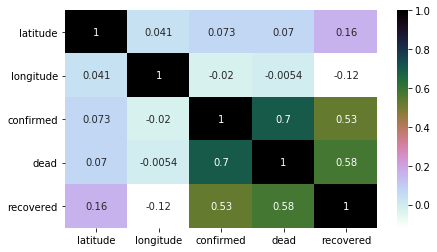

In [186]:
df_states_needed.fillna(0)
plt.figure(figsize=(7,4))
sns.heatmap(df_states_needed.corr(),annot=True,cmap='cubehelix_r')#draws heatmap with input as the correlation matrix calculated by (iris_data.corr())
plt.show()

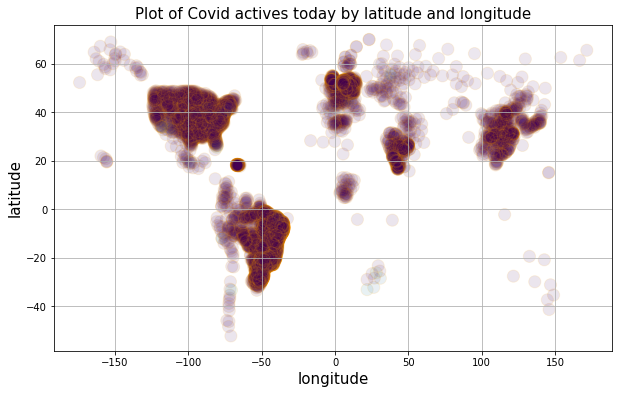

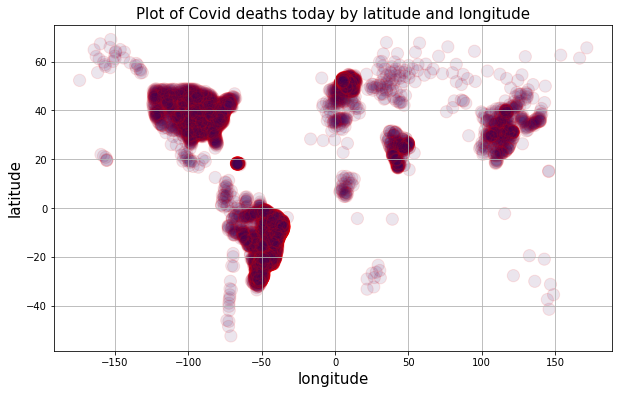

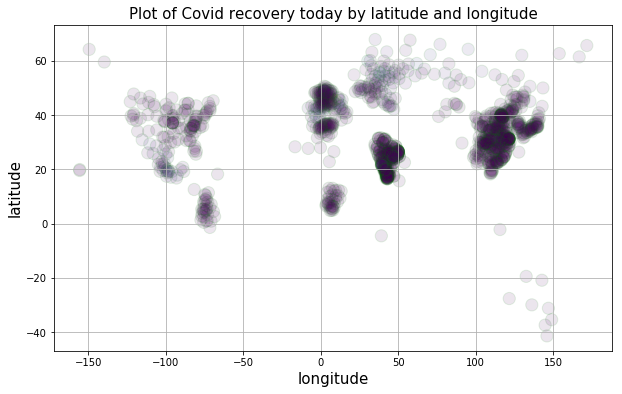

In [187]:
plt.figure(figsize=(10,6))
plt.scatter(df_states_needed['longitude'],df_states_needed['latitude'],c=df_states_needed['confirmed'],edgecolors='orange',alpha=0.10,s=150)
plt.grid(True)
plt.xlim()
plt.title("Plot of Covid actives today by latitude and longitude",fontsize=15)
plt.xlabel("longitude",fontsize=15)
plt.ylabel("latitude",fontsize=15)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(df_states_needed['longitude'],df_states_needed['latitude'],c=df_states_needed['dead'],edgecolors='red',alpha=0.10,s=150)
plt.grid(True)
plt.xlim()
plt.title("Plot of Covid deaths today by latitude and longitude",fontsize=15)
plt.xlabel("longitude",fontsize=15)
plt.ylabel("latitude",fontsize=15)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(df_states_needed['longitude'],df_states_needed['latitude'],c=df_states_needed['recovered'],edgecolors='green',alpha=0.10,s=150)
plt.grid(True)
plt.xlim()
plt.title("Plot of Covid recovery today by latitude and longitude",fontsize=15)
plt.xlabel("longitude",fontsize=15)
plt.ylabel("latitude",fontsize=15)
plt.show()


# KDD for predicting location based covid prediction and zoning the address

In [188]:
#ML to find covid index for a given geographic location

from sklearn.model_selection import train_test_split
X=df_states_needed[['latitude','longitude']]
#y=df_states_needed['confirmed']
y=df_states_needed[['confirmed','dead','recovered']].fillna(0)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(7917, 2)
(1980, 2)


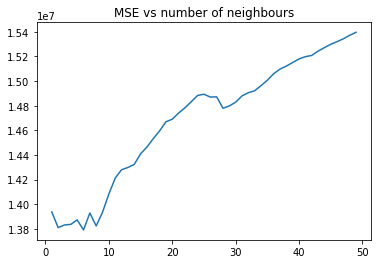

In [200]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
a=[]
c=[]
for n_value in  range(1,50):
    knnr = KNeighborsRegressor(n_neighbors = n_value)
    knnr.fit(X_train, y_train)
    a.append(n_value)
    #plt.scatter(x=n_value,y=format(np.power(y_test-knnr.predict(X_test),2).mean()),s=60,c='red')
    #print ("The MSE is:",mean_squared_error(y_test,knnr.predict(X_test))," ",n_value)
    c.append(mean_squared_error(y_test,knnr.predict(X_test)))
plt.plot(a,c)
plt.title("MSE vs number of neighbours")
plt.show()

In [203]:
params = {'n_neighbors': list(range(2,10))}
knnr = KNeighborsRegressor()
model = GridSearchCV(knnr, params, cv=5)
model.fit(X_train,y_train)
model.best_params_

{'n_neighbors': 9}

In [204]:
#addressSearch = "277 communipaw ave jersey city new jersey 07205"
#addressSearch = "South Toe, NC 28714"
#addressSearch = "1255 E University Dr. Tempe | AZ 85281-4950"
#addressSearch = "balaji place cary"
#addressSearch = "green gables heritage place"
#addressSearch = "3170 bethel road columbus ohio"
#addressSearch = "2572 crescent view drive"
#addressSearch = "navaho arizona"
#addressSearch = "point loma san diego"
addressSearch = "murphy NC"
#addressSearch="3530 Alister ave sw concord 28027"

from sklearn.neighbors import KNeighborsRegressor
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="addresscodingLatLong")
location = geolocator.geocode(addressSearch)
stateOfData = location_given.raw.get('address').get('state')
knnr = KNeighborsRegressor(n_neighbors = model.best_params_.get('n_neighbors'))
knnr.fit(X_train, y_train)
print("Your coordinates are ",location.latitude,location.longitude)
covid_prediction=knnr.predict([[location.latitude,location.longitude]])
print("Todays covid confirmed index based on your location is - ", round(covid_prediction[0][0]))
print("Todays covid deaths index based on your location is - ", round(covid_prediction[0][1]))
#print("Todays covid recovery index based on your location is - ", round(covid_prediction[0][2]))

confirmed_numbers=arr = df_states_needed['confirmed'].to_numpy()[df_states_needed['confirmed'].to_numpy() != 0]
redvalue=np.percentile(confirmed_numbers, 95)
yellowvalue=np.percentile(confirmed_numbers, 75)
greenvalue=np.percentile(confirmed_numbers, 55)

def returnZone(covid_prediction):
    if covid_prediction>redvalue:
        return "Red Zone"
    elif covid_prediction>yellowvalue:
        return "Yellow Zone"
    else:
        return "Green Zone"



print("You are in ", returnZone(covid_prediction[0][0]))

Your coordinates are  35.0875836 -84.0346315
Todays covid confirmed index based on your location is -  204
Todays covid deaths index based on your location is -  4
You are in  Green Zone


# Import of data for time series predictions - this is to predict the future active rates at address of interest based on trend in state

In [205]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [206]:
df_covid19_county = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

# EDA of data for time series predictions - this is to predict the future active rates at address of interest based on trend in state

In [207]:
df_covid19_county.tail()

,date,county,state,fips,cases,deaths
389197,2020-07-31,Sweetwater,Wyoming,56037.0,240,2
389198,2020-07-31,Teton,Wyoming,56039.0,335,1
389199,2020-07-31,Uinta,Wyoming,56041.0,254,1
389200,2020-07-31,Washakie,Wyoming,56043.0,47,5
389201,2020-07-31,Weston,Wyoming,56045.0,5,0


In [208]:
grouping = df_covid19_county[df_covid19_county['date']=='2020-07-30']

print(grouping)

              date      county    state     fips  cases  deaths
382767  2020-07-30     Autauga  Alabama   1001.0   1002      21
382768  2020-07-30     Baldwin  Alabama   1003.0   3028      21
382769  2020-07-30     Barbour  Alabama   1005.0    585       5
382770  2020-07-30        Bibb  Alabama   1007.0    352       2
382771  2020-07-30      Blount  Alabama   1009.0    731       3
...            ...         ...      ...      ...    ...     ...
385980  2020-07-30  Sweetwater  Wyoming  56037.0    237       2
385981  2020-07-30       Teton  Wyoming  56039.0    331       1
385982  2020-07-30       Uinta  Wyoming  56041.0    247       1
385983  2020-07-30    Washakie  Wyoming  56043.0     45       5
385984  2020-07-30      Weston  Wyoming  56045.0      5       0

[3218 rows x 6 columns]


              date         county          state     fips   cases  deaths
384619  2020-07-30  New York City       New York      NaN  229551   22996
383377  2020-07-30           Cook       Illinois  17031.0  104691    4872
382970  2020-07-30    Los Angeles     California   6037.0  185872    4552
384084  2020-07-30          Wayne       Michigan  26163.0   26949    2800
384618  2020-07-30         Nassau       New York  36059.0   43158    2706
384543  2020-07-30          Essex     New Jersey  34013.0   19684    2100
384638  2020-07-30        Suffolk       New York  36103.0   43170    2043
384538  2020-07-30         Bergen     New Jersey  34003.0   20667    2040
382868  2020-07-30       Maricopa        Arizona   4013.0  114852    2011
383995  2020-07-30      Middlesex  Massachusetts  25017.0   25617    1974


<BarContainer object of 10 artists>

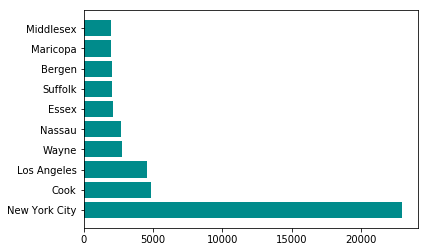

In [209]:
df = grouping.nlargest(10,'deaths')
print(df
     )
plt.barh(df['county'],df['deaths'],color="darkcyan")

In [210]:
state = (df_covid19_county['state'] ==stateOfData)
df_state = df_covid19_county.loc[state]
print(df_state)
county = (df_state['county']=='Mecklenburg')
df_county = df_state.loc[county]
print(df_county)

              date   county           state     fips  cases  deaths
483     2020-03-03     Wake  North Carolina  37183.0      1       0
520     2020-03-04     Wake  North Carolina  37183.0      1       0
567     2020-03-05     Wake  North Carolina  37183.0      1       0
630     2020-03-06  Chatham  North Carolina  37037.0      1       0
631     2020-03-06     Wake  North Carolina  37183.0      1       0
...            ...      ...             ...      ...    ...     ...
387961  2020-07-31    Wayne  North Carolina  37191.0   2282      37
387962  2020-07-31   Wilkes  North Carolina  37193.0    723       9
387963  2020-07-31   Wilson  North Carolina  37195.0   1370      33
387964  2020-07-31   Yadkin  North Carolina  37197.0    480       6
387965  2020-07-31   Yancey  North Carolina  37199.0     72       0

[12708 rows x 6 columns]
              date       county           state     fips  cases  deaths
1532    2020-03-12  Mecklenburg  North Carolina  37119.0      2       0
1826    2020-0

# Prediction using Active Cases in a state Using ARIMA for timeseries

In [211]:
df_county['active_count'] = df_county.cases.diff()

In [212]:
print(df_county['active_count'].sum())

20500.0


In [213]:
df_active = df_county[['date','active_count']].copy()

print(df_active)

              date  active_count
1532    2020-03-12           NaN
1826    2020-03-13           0.0
2180    2020-03-14           0.0
2592    2020-03-15           2.0
3054    2020-03-16           0.0
...            ...           ...
375057  2020-07-27         212.0
378273  2020-07-28         227.0
381490  2020-07-29         217.0
384708  2020-07-30         337.0
387925  2020-07-31         241.0

[142 rows x 2 columns]


In [214]:
df_active['date']=pd.to_datetime(df_active['date'])

df_active.set_index('date',inplace = True)

In [215]:
df_active['active_count'] = df_active['active_count'].fillna(0)

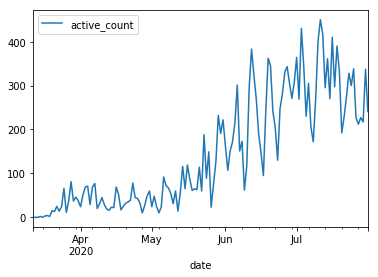

In [216]:
df_active.plot()

In [217]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

active_result=adfuller(df_active['active_count'])

In [218]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test_active(active_count):
    result_active=adfuller(active_count)
    labels_active = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result_active,labels_active):
        print(label+' : '+str(value) )
    if result_active[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [219]:
adfuller_test_active(df_active['active_count'])

ADF Test Statistic : -0.9068443782751411
p-value : 0.7857101099450314
#Lags Used : 6
Number of Observations Used : 135
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


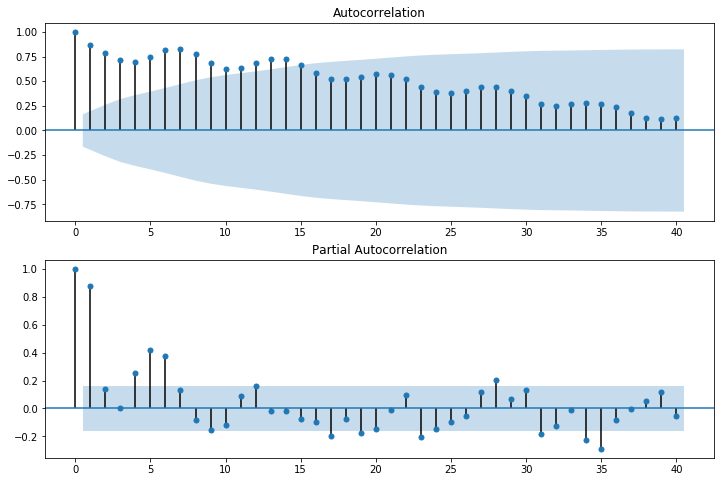

In [220]:
fig1 = plt.figure(figsize=(12,8))
ax1_1 = fig1.add_subplot(211)
fig1 = sm.graphics.tsa.plot_acf(df_active['active_count'],lags=40,ax=ax1_1)
ax2_1 = fig1.add_subplot(212)
fig1 = sm.graphics.tsa.plot_pacf(df_active['active_count'],lags=40,ax=ax2_1)

In [221]:
print(df_active['active_count'])
from statsmodels.tsa.arima_model import ARIMA
model_active=ARIMA(df_active['active_count'],order=(5,0,4))
model_fit_active=model_active.fit()

date
2020-03-12      0.0
2020-03-13      0.0
2020-03-14      0.0
2020-03-15      2.0
2020-03-16      0.0
              ...  
2020-07-27    212.0
2020-07-28    227.0
2020-07-29    217.0
2020-07-30    337.0
2020-07-31    241.0
Name: active_count, Length: 142, dtype: float64


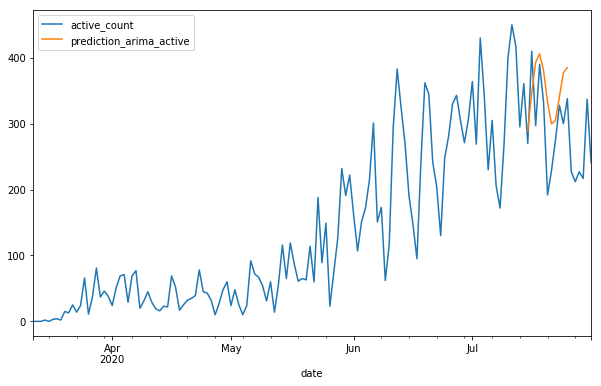

In [222]:
df_active['prediction_arima_active']=model_fit_active.predict(start=125,end=135,dynamic=True)
df_active[['active_count','prediction_arima_active']].plot(figsize=(10,6))

In [223]:
from pandas.tseries.offsets import DateOffset
add_dates_active = [df_active.index[-1]+DateOffset(days=x) for x in range(0,10)]

future_dates_active = pd.DataFrame(index=add_dates_active[1:],columns=df_active.columns)

In [224]:
future_dates_active.head() 

,active_count,prediction_arima_active
2020-08-01,NaN,NaN
2020-08-02,NaN,NaN
2020-08-03,NaN,NaN
2020-08-04,NaN,NaN
2020-08-05,NaN,NaN


In [225]:
future_df_active_ar=pd.concat([df_active,future_dates_active])

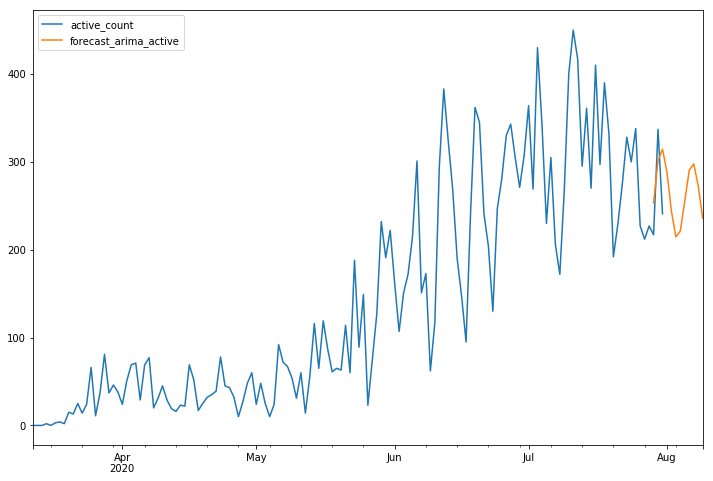

In [226]:
future_df_active_ar['forecast_arima_active'] = model_fit_active.predict(start = 139, end = 150, dynamic= True)  
future_df_active_ar[['active_count', 'forecast_arima_active']].plot(figsize=(12, 8))

In [227]:
#since we have used 10 in arima model to predict 10 days into future first row will always be current date
future_df_active_ar['forecast_arima_active'].tail(10)

2020-07-31    314.509067
2020-08-01    288.301847
2020-08-02    243.895314
2020-08-03    214.608049
2020-08-04    221.319369
2020-08-05    256.210289
2020-08-06    290.585049
2020-08-07    297.675085
2020-08-08    272.807954
2020-08-09    235.790967
Name: forecast_arima_active, dtype: float64

# Combining the output of the two models - a) deriving the active cases of COVID based on a address done using KNN b) extrapolating those numbers and predicting future values of COVID based on ARIMA modelling of trend in the state

In [230]:
print("Given address is: ", addressSearch)
location_string = str(location.latitude) + ", " + str(location.longitude)
location_given = geolocator.reverse(location_string)
print("Your state is : ", location_given.raw.get('address').get('state'))
print("Todays covid confirmed index based on your location is - ", round(covid_prediction[0][0]))
print("Todays covid deaths index based on your location is - ", round(covid_prediction[0][1]))
print("You are in ", returnZone(covid_prediction[0][0]))
compareFraction = round(covid_prediction[0][0])/future_df_active_ar['forecast_arima_active'].tail(10)[0]
covid_area_predictions = future_df_active_ar['forecast_arima_active'].tail(10)*compareFraction
print("The future 10 day active COVID predictions for ur location based on your state trend is: ")
print(round(covid_area_predictions))


Given address is:  murphy NC
Your state is :  North Carolina
Todays covid confirmed index based on your location is -  204
Todays covid deaths index based on your location is -  4
You are in  Green Zone
The future 10 day active COVID predictions for ur location based on your state trend is: 
2020-07-31    204.0
2020-08-01    187.0
2020-08-02    158.0
2020-08-03    139.0
2020-08-04    144.0
2020-08-05    166.0
2020-08-06    188.0
2020-08-07    193.0
2020-08-08    177.0
2020-08-09    153.0
Name: forecast_arima_active, dtype: float64
